<a href="https://colab.research.google.com/github/lawrence773/e-commerce-analysis/blob/main/E_Commerce_Retail_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-Commerce Data Analysis**

<img src='https://mylittlebigweb.com/wp-content/uploads/2024/01/creer-boutique-amazon-guide-jpg.webp' width='700'>

In this project, I've cleaned and analyzed an e-commerce dataset spanning over two years (12/2009-12/2011) in order to familiarize myself with retail datasets and business analysis terms and methods. Besides the below questions, I am planning to do a time series analysis in the near future.

The dataset was downloaded from [here](https://archive.ics.uci.edu/dataset/502/online+retail+ii). The shorter version can be found on [kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data/data).

The questions I'd like to answer, are the following:
1. What were the sales figures for each country?
2. What was the overall sales trend?
3. How many new customers were there each month?
4. When did customers make the most purchases?
5. What are the most frequent terms in the company's product descriptions?
6. Which was the best-selling product in each country?
7. Which were the most popular products in 2009, 2010 and 2011?
8. What was the product return rate?
9. Which were the most often returned products?
10. When were the largest orders made?
11. Which customers made the largest orders?
12. Who were the biggest clients based on sales?
13. Who were the most valued clients based on the RFM score?


In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import re

#from scipy.stats.mstats import mode

# Natural language processing and clustering
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Data visualization
import matplotlib.pyplot as plt
from importlib import reload
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud

In [2]:
# Getting the floating point numbers in order
pd.options.display.float_format = '{:,.2f}'.format

# Data Exploration and Cleaning

The original file was a .xlsx file with two sheets which I've decided to split up into two .csv files to speed up the loading process.

In [3]:
# Importing and concatenating the sheets of the online_retail_II.xlsx file
df1 = pd.read_csv('online_retail_IIa.csv', encoding='unicode_escape')
df2 = pd.read_csv('online_retail_IIb.csv', encoding='unicode_escape')
commerce_df = pd.concat([df1, df2])

In [4]:
# Let's take a look at our data
commerce_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,"13,085.00",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,"13,085.00",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,"13,085.00",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,"13,085.00",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,"13,085.00",United Kingdom


The documentation on the website gives the following information on the variables:


> **Invoice**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

> **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

> **Description**: Product (item) name. Nominal.

> **Quantity**: The quantities of each product (item) per transaction. Numeric.

> **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.

> **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (£).

> **Customer ID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

> **Country**: Country name. Nominal. The name of the country where a customer resides.

In [5]:
commerce_df.shape

(1067371, 8)

Over 1,065,000 rows to work with!

In [6]:
# See how many missing values we have in these columns
commerce_df.isna().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [7]:
# Calculating a 5% threshold to check the percentage of NaN rows against it
threshold = len(commerce_df) * 0.05
print(threshold)

53368.55


It looks like there are over 240,000 missing customer IDs and over 4,400 missing product descriptions. The former can perhaps be the result of shopping online without a registered account. Since we have no way of correcting it and dropping those lines would seriously alter our analysis, we can leave those rows as they are for now and get rid of them later when we analyze individual customers. The missing description rows, however, can be dropped.

In [8]:
# Creating a filter
cols_to_drop = commerce_df.columns[commerce_df.isna().sum() <= threshold]

# Dropping missing value rows for columns below the threshold
commerce_df.dropna(subset=cols_to_drop, inplace=True)
print(commerce_df.isna().sum())

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    238625
Country             0
dtype: int64


In [9]:
# Let's check for duplicate rows
duplicated_rows = commerce_df.duplicated()
duplicated_rows_df = commerce_df[duplicated_rows]
duplicated_rows_df.shape

(34228, 8)

The above 34,000+ rows are the ones that are identical to another row in all column values. Let's drop these rows.

In [10]:
# Keeping the last occurrences of the respective rows
commerce_df.drop_duplicates(keep='last', inplace=True)

In [11]:
# Let's check the data types of our columns
commerce_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1028761 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1028761 non-null  object 
 1   StockCode    1028761 non-null  object 
 2   Description  1028761 non-null  object 
 3   Quantity     1028761 non-null  int64  
 4   InvoiceDate  1028761 non-null  object 
 5   Price        1028761 non-null  float64
 6   Customer ID  797885 non-null   float64
 7   Country      1028761 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 70.6+ MB


At first glance, we should change the the InvoiceDate to datetime, and the Customer ID to string as we are not going to do computations with those.

In [12]:
# Filling the customer ID column with 'No data' & converting column values
commerce_df['Customer ID'] = commerce_df['Customer ID'].fillna('No data')
commerce_df['Customer ID'] = commerce_df['Customer ID'].astype('str')
commerce_df['InvoiceDate'] = pd.to_datetime(commerce_df['InvoiceDate'])

In [13]:
# Let's see some quick descriptive statistics on our data
commerce_df.describe(include='object')

,Invoice,StockCode,Description,Customer ID,Country
count,1028761,1028761,1028761,1028761,1028761
unique,49353,4950,5698,5943,43
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,No data,United Kingdom
freq,1114,5653,5740,230876,944046


The shop has managed to sell its products in 43 different countries and had almost 50,000 transactions! They had nearly 6,000 clients and 5700 unique products based on the descriptions.

In [14]:
# Let's do the same for numerical values
commerce_df.describe()

,Quantity,InvoiceDate,Price
count,"1,028,761.00",1028761,"1,028,761.00"
mean,10.19,2011-01-04 01:16:01.831971328,4.63
min,"-80,995.00",2009-12-01 07:45:00,"-53,594.36"
25%,1.00,2010-07-05 14:41:00,1.25
50%,3.00,2010-12-09 14:09:00,2.10
75%,10.00,2011-07-27 15:16:00,4.15
max,"80,995.00",2011-12-09 12:50:00,"38,970.00"
std,172.37,NaN,122.65


It's interesting to see that although the average unit price is £4.63, and the average ordered unit quantity is 10.19 units, there are some extreme min and max values in both columns which should be further investigated as these numbers might be outliers and can skew our data.

In [15]:
# Let's see the highest prices in the dataset
commerce_df.sort_values(by='Price', ascending=False).head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,"38,970.00",15098.0,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,"25,111.09",No data,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,"25,111.09",17399.0,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,"18,910.69",No data,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,"17,836.46",No data,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,"16,888.02",No data,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,"16,453.71",No data,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,"13,541.33",No data,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,"13,541.33",No data,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,"13,541.33",No data,United Kingdom


We can see that most of the highest unit prices have values related to various fees like Amazon and postage charges in the StockCode column. If we are going to analyze actual purchases and returns not counting these logistical fees, we need to create further subsets to these data frames. As we have seen above, the regular product stock codes start with numbers, while unique stock codes start with letters. Let's find them.

In [16]:
# Defining a regular expression to catch values starting with letters and then filtering the StockCode column
regex_pattern = r"^[a-zA-Z]+"
unique_codes = commerce_df['StockCode'].str.contains(regex_pattern, na=False)

# Filtering the data frame to show the rows where the unique_codes value is True, then checking the unique values in the StockCode column
unique_codes_list = commerce_df[unique_codes]['StockCode'].unique().tolist()
print(unique_codes_list)

['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004', 'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001', 'DCGS0072', 'gift_0001_80', 'gift_0001_20', 'DCGS0044', 'TEST002', 'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30', 'PADS', 'ADJUST', 'm', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B', 'DCGS0041', 'gift_0001_70', 'DCGS0037', 'DCGSSBOY', 'DCGSSGIRL', 'ADJUST2', 'gift_0001_40', 'SP1002', 'DCGS0062', 'AMAZONFEE', 'DCGS0073', 'DCGS0067', 'CRUK']


Now that we have a list of the unique codes, we have to take a look at their rows to decide whether any of them designate actual products.

In [17]:
# Let's see the rows which have stock codes from the above list
temp_df = commerce_df[commerce_df['StockCode'].isin(unique_codes_list) & ((commerce_df['Price'] > 0) | (commerce_df['Price'] < 0))]

# Drop duplicates so we can see one row with each code
temp_df = temp_df.drop_duplicates('StockCode')
temp_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.0,France
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.0,United Kingdom
2377,489597,DCGS0058,MISO PRETTY GUM,1,2009-12-01 14:28:00,0.83,No data,United Kingdom
2378,489597,DCGS0068,DOGS NIGHT COLLAR,1,2009-12-01 14:28:00,8.65,No data,United Kingdom
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,No data,United Kingdom
2697,489609,M,Manual,1,2009-12-01 14:50:00,4.00,No data,United Kingdom
8371,490074,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2009-12-03 14:39:00,17.35,No data,United Kingdom
8373,490074,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-03 14:39:00,16.48,No data,United Kingdom
9292,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,50.00,14156.0,EIRE
18410,C490943,BANK CHARGES,Bank Charges,-1,2009-12-08 14:08:00,15.00,16703.0,United Kingdom


After examining the above list, we can take out extra-fee-related stock codes and add them to a list of miscellaneous codes.

In [18]:
# Creating the unique codes list
misc_codes = ['POST', 'D', 'DOT', 'M', 'C2', 'BANK CHARGES', 'ADJUST', 'm', 'S', 'B', 'ADJUST2', 'AMAZONFEE', 'CRUK']

Now that we have the list of codes that we are not interested in for now, we can filter our commerce_df using the list. This way, the remaining rows should be the actual products that were purchased.

In [19]:
# Let's create a subset using ~
commerce_products_df = commerce_df[~commerce_df['StockCode'].isin(misc_codes)]

In [20]:
print(f"Removed rows containing extra fees: {commerce_df.shape[0] - commerce_products_df.shape[0]}")

Removed rows containing extra fees: 5670


It seems that in total, there were over **5,600** rows in the dataset that were related to miscellaneous fees and not products.




In [21]:
# Let's take another look at the cleaned data
commerce_products_df.sort_values(by='Price', ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
192196,507637,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-05-10 14:55:00,"1,157.15",No data,United Kingdom
136403,502451,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 14:14:00,867.79,No data,United Kingdom
222671,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom
180997,506571,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-30 13:04:00,408.40,No data,United Kingdom


The extra fees are gone; however, we notice that there is some discrepancies at indexes 222671 and 222682. The same product, a batch of 60 wicker baskets was logged in two different ways. In one case, it was logged as a single unit, while in the other case, it was logged as 60. Since order values are calculated as the multiplication of the quantities and prices, this here is a serious logging error which would result in skewed data. Let's investigate this further.

In [22]:
# Filling up empty cells with strings so that we can search them
commerce_products_df['Description'] = commerce_products_df['Description'].fillna('No data')

# Creating a subset for baskets
wicker_baskets = commerce_products_df[commerce_products_df['Description'].str.contains('PICNIC BASKET WICKER 60')]
print(wicker_baskets)

<ipython-input-22-0b0e658462c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commerce_products_df['Description'] = commerce_products_df['Description'].fillna('No data')


       Invoice StockCode                     Description  Quantity  \
222671  556444     22502  PICNIC BASKET WICKER 60 PIECES        60   
222682  556446     22502  PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  Price Customer ID         Country  
222671 2011-06-10 15:28:00 649.50     15098.0  United Kingdom  
222682 2011-06-10 15:33:00 649.50     15098.0  United Kingdom  


Luckily, we only have two rows of this particular product, so we can correct this error here.

In [23]:
# Change the quantity value from 60 to 1
commerce_products_df.loc[222671, 'Quantity'] = 1
print(commerce_products_df[commerce_products_df['Description'] == 'PICNIC BASKET WICKER 60 PIECES'])

       Invoice StockCode                     Description  Quantity  \
222671  556444     22502  PICNIC BASKET WICKER 60 PIECES         1   
222682  556446     22502  PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  Price Customer ID         Country  
222671 2011-06-10 15:28:00 649.50     15098.0  United Kingdom  
222682 2011-06-10 15:33:00 649.50     15098.0  United Kingdom  


That's better. Now, let's examine the order quantities.

In [24]:
# Now, let's examine the highest and lowest quantities seen earlier
highest_v_lowest_order_quantity = commerce_products_df[(commerce_products_df['Quantity'] == commerce_products_df['Quantity'].max()) | (commerce_products_df['Quantity'] == commerce_products_df['Quantity'].min())]
highest_v_lowest_order_quantity

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


As expected based on the matching quantities but opposite sign, the second row is the cancellation of the first one. However, even though the second invoice is marked with a 'C', the invoice number is different, which makes it difficult to filter out cancelled orders. Unfortunately, there's no easy way of solving it so let's try to get around this issue by starting with adding an extra column and flagging the 'C' rows.

In [25]:
# Let's add an extra row to help with filtering and with the below analysis
commerce_products_df['OrderValue'] = commerce_products_df['Quantity'] * commerce_products_df['Price']

<ipython-input-25-0ae0e25667ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commerce_products_df['OrderValue'] = commerce_products_df['Quantity'] * commerce_products_df['Price']


In [26]:
# Creating a mask to filter cancellation rows
cancel_mask = commerce_products_df['Invoice'].str.startswith('C')

# Separating cancellation and regular purchase rows
returns_and_canc = commerce_products_df[cancel_mask].copy()
purchase_df = commerce_products_df[~cancel_mask].copy()

# We'll loop through each row in the cancellation DataFrame and find matching
# rows in the purchase DataFrame
rows_to_drop = []

# Finding matching rows in the purchase dataframe; if the negative quantities
# and order values don't match, it might also mean that the order was only
# partially cancelled, so we'll leave it in
for index, row in returns_and_canc.iterrows():
    matching_row = purchase_df[
        (purchase_df['Customer ID'] == row['Customer ID']) &
        (purchase_df['Quantity'] == -row['Quantity']) &
        (purchase_df['OrderValue'] == -row['OrderValue'])
    ]

    # If a match is found, we append both the cancellation and the matching row index to rows_to_drop
    if not matching_row.empty:
        rows_to_drop.append(index)  # cancellation row index
        rows_to_drop.append(matching_row.index[0])  # corresponding purchase row index

# Dropping the rows from the original DataFrame
sales_only = commerce_products_df.drop(rows_to_drop)

# Let's remove the remaining rows with 'C' invoices
sales_only = sales_only[~sales_only['Invoice'].str.startswith('C')]

# Let's see the cleaned data frame
print(sales_only)

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
5       489434     22064           PINK DOUGHNUT TRINKET POT         24   
...        ...       ...                                  ...       ...   
541904  581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country  OrderValue  
0      2009-12-01 07:45

In [27]:
print(f"Rows removed due to cancellations and/or returns: {commerce_products_df.shape[0] - sales_only.shape[0]}")

Rows removed due to cancellations and/or returns: 40133


In [28]:
# Now, let's take a look at the cancellations and returns
print(returns_and_canc.sort_values(by='Quantity', ascending=True).head())
print(returns_and_canc.shape)

        Invoice StockCode                          Description  Quantity  \
540422  C581484     23843          PAPER CRAFT , LITTLE BIRDIE    -80995   
61624   C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
4268    C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR     -9360   
359669  C524235     21088         SET/6 FRUIT SALAD PAPER CUPS     -7128   
359670  C524235     21096      SET/6 FRUIT SALAD  PAPER PLATES     -7008   

               InvoiceDate  Price Customer ID         Country  OrderValue  
540422 2011-12-09 09:27:00   2.08     16446.0  United Kingdom -168,469.60  
61624  2011-01-18 10:17:00   1.04     12346.0  United Kingdom  -77,183.60  
4268   2010-12-02 14:23:00   0.03     15838.0  United Kingdom     -280.80  
359669 2010-09-28 11:02:00   0.08     14277.0          France     -570.24  
359670 2010-09-28 11:02:00   0.13     14277.0          France     -911.04  
(17920, 9)


Nearly 18,000 rows with cancellations after removing the rows with extra fees.

In [29]:
# Quick check on the top and bottom quantities in the sales_only subset
print(sales_only[['Description', 'Quantity', 'Customer ID', 'OrderValue']].sort_values(by='Quantity', ascending=False).head(15))
print(sales_only[['Description', 'Quantity', 'Customer ID', 'OrderValue']].sort_values(by='Quantity', ascending=True).head(15))

                                Description  Quantity Customer ID  OrderValue
90857    BLACK AND WHITE PAISLEY FLOWER MUG     19152     13902.0    1,915.20
127166          SET/6 STRAWBERRY PAPER CUPS     12960     13902.0    1,296.00
127168          SET/6 WOODLAND PAPER PLATES     12960     13902.0    1,296.00
127169            SET/6 WOODLAND PAPER CUPS     12744     13902.0    1,274.40
502122       ASSTD DESIGN 3D PAPER STICKERS     12540     13256.0        0.00
127167        SET/6 STRAWBERRY PAPER PLATES     12480     13902.0    1,248.00
192197           FLAG OF ST GEORGE CAR FLAG     10200     No data        0.00
135030         PACK OF 12 WOODLAND TISSUES      10000     17940.0    2,500.00
135027     PACK OF 12 PINK PAISLEY TISSUES      10000     17940.0    2,500.00
135028             PACK OF 12 SUKI TISSUES      10000     17940.0    2,500.00
135029       PACK OF 12 RED SPOTTY TISSUES      10000     17940.0    2,500.00
93677       SMALL FAIRY CAKE FRIDGE MAGNETS      9456     13902.

Our fully cancelled purchases have been successfully removed. However,  we can spot that some cells contain the reasons why a certain product was returned/thrown away. Yet another inconsistent technique. We also see that these rows come with negative quantitites. We could try to filter these rows based on the lowercase descriptions.

In [30]:
# Filtering for lowercase values in the Description column
reasons = sales_only['Description'].str.lower()
print(reasons.value_counts().head(10))

Description
white hanging heart t-light holder    5473
regency cakestand 3 tier              3813
jumbo bag red retrospot               3251
assorted colour bird ornament         2808
party bunting                         2656
lunch bag  black skull.               2359
strawberry ceramic trinket box        2297
jumbo storage bag suki                2288
jumbo shopper vintage red paisley     2169
heart of wicker small                 2164
Name: count, dtype: int64


This method doesn't work since we can see that the above descriptions are actual product description written in lowercase. Let's try to separate them by negative quantity values.

In [31]:
# See what appears in negative quantities
rejects_and_misc = sales_only[sales_only['Quantity'] < 0]
print(f"Rows with negative quantity values: {rejects_and_misc.shape[0]}")

# Sort the resulting df in ascending order
print(rejects_and_misc[['Description', 'Quantity', 'Customer ID', 'OrderValue']].sort_values(by='Quantity', ascending=True).head(10))

Rows with negative quantity values: 750
                         Description  Quantity Customer ID  OrderValue
225530  printing smudges/thrown away     -9600     No data       -0.00
225529  printing smudges/thrown away     -9600     No data       -0.00
225528  Printing smudges/thrown away     -9058     No data       -0.00
428975                             ?     -9000     No data       -0.00
194372           Zebra invcing error     -9000     No data       -0.00
437008                    Given away     -8800     No data       -0.00
258814        Ebay sales by the box.     -7100     No data       -0.00
269558                    given away     -7000     No data       -0.00
115818                    throw away     -5368     No data       -0.00
136409                    ebay sales     -5200     No data       -0.00


As we can see from the above, the description column for rows with negative quantities come with all kinds of information in 750 rows. Besides reasons for getting rid of damaged products, we also have ebay sales and giveaways here.

In [32]:
# Quick check for ebay sales
ebay_sales = rejects_and_misc[rejects_and_misc['Description'].str.contains('ebay|EBAY|Ebay')]
print(ebay_sales[['Description', 'Quantity', 'Customer ID', 'OrderValue']])

                   Description  Quantity Customer ID  OrderValue
114238              ebay sales     -3300     No data       -0.00
136409              ebay sales     -5200     No data       -0.00
136410              ebay sales     -5000     No data       -0.00
184701              ebay sales      -130     No data       -0.00
258814  Ebay sales by the box.     -7100     No data       -0.00
279251                    ebay        -4     No data       -0.00
279255                    ebay        -5     No data       -0.00
279256                    ebay       -10     No data       -0.00
279257                    ebay       -11     No data       -0.00
279258                    ebay        -7     No data       -0.00


Only 10 orders were sold on ebay. Since this platform doesn't concern us in the present case, we will drop these rows along the rejects.

In [33]:
# Removing 750 rows with negative quantities
sales_only = sales_only[~sales_only.index.isin(rejects_and_misc.index)]

In [34]:
# Final checks
print(sales_only.isna().sum())
print(sales_only.shape)
print(sales_only[['Description', 'Quantity', 'Customer ID', 'OrderValue']].sort_values(by='Quantity', ascending=True).head())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
OrderValue     0
dtype: int64
(981510, 9)
                        Description  Quantity Customer ID  OrderValue
245961  FANNY'S REST STOPMETAL SIGN         1     No data        4.21
216929  HANGING METAL HEART LANTERN         1     14606.0        1.65
216930   HANGING METAL STAR LANTERN         1     14606.0        1.65
393300             PICTURE DOMINOES         1     No data        3.36
216932      HANGING METAL BIRD BATH         1     14606.0        7.95


# Data Analysis & Visualization
Now, we can start analyzing our data and answering our questions.

### **1**. What were the sales figures for each country? & **2**. What was the overall sales trend?


In [35]:
# Let's add a new column to our data frame
sales_only['Year'] = sales_only['InvoiceDate'].dt.year

In [36]:
# Let's see the unique countries in the dataset
countries = sales_only['Country'].unique()
print(countries)

['United Kingdom' 'France' 'Australia' 'EIRE' 'Germany' 'Portugal'
 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain' 'Cyprus'
 'Belgium' 'Greece' 'Norway' 'Austria' 'Sweden' 'United Arab Emirates'
 'Finland' 'Italy' 'Switzerland' 'USA' 'Unspecified' 'Japan' 'Malta'
 'Bahrain' 'RSA' 'Bermuda' 'Hong Kong' 'Singapore' 'Thailand' 'Israel'
 'Lithuania' 'Nigeria' 'West Indies' 'Lebanon' 'Korea' 'Brazil' 'Canada'
 'Iceland' 'Saudi Arabia' 'Czech Republic' 'European Community']


Again, we see some inconsistencies in the dataset. Besides countries, we also have regional names like West Indies and European Community, even though many individual countries belong to the latter. Other names will need to be changed in order to plot them. RSA stands for the Republic of South Africa, while Éire is the Irish Gaelic name of Ireland.

In [37]:
sales_only['Country'] = sales_only['Country'].replace('EIRE', 'Ireland')
sales_only['Country'] = sales_only['Country'].replace('RSA', 'South Africa')

In [38]:
# Let's group by country and see the total sales amounts
sales_per_country = sales_only.groupby('Country')['OrderValue'].sum().sort_values(ascending=False)
print(sales_per_country)

Country
United Kingdom         16,029,382.75
Ireland                   600,906.82
Netherlands               539,329.77
Germany                   371,818.26
France                    291,851.43
Australia                 164,947.82
Switzerland                91,920.16
Spain                      85,804.83
Sweden                     83,431.06
Denmark                    61,248.63
Belgium                    55,921.67
Portugal                   46,435.45
Channel Islands            42,100.68
Japan                      41,136.08
Norway                     37,781.50
Italy                      27,794.15
Finland                    24,714.35
Cyprus                     23,854.11
Austria                    19,711.11
Greece                     18,688.64
Singapore                  13,158.16
Hong Kong                  13,108.75
Israel                     11,096.42
Unspecified                10,863.86
Poland                      9,858.09
United Arab Emirates        9,809.59
USA                         6,

Perhaps it's not a surprise that a UK-based e-commerce shop made most of its sales within the country. Let's see these numbers on a choropleth map.

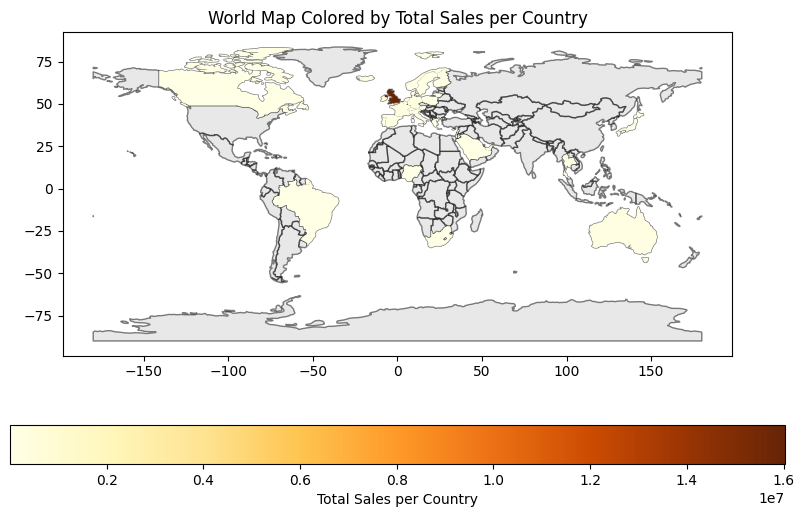

In [39]:
# Let's plot this on the world map using geopandas (I've downloaded the map manually, since it's been deprecated)
reload(plt)

world = gpd.read_file('/content/map/ne_110m_admin_0_countries.shp')

# Setting the index for geopandas 'NAME' and merging the map with our data
world = world.set_index('NAME').join(sales_per_country)

# Defining a fig and an ax to plot on
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(color='lightgrey', edgecolor="black", alpha=0.5, ax=ax)
world.plot(column='OrderValue', cmap='YlOrBr', legend=True,
                 legend_kwds={'label': "Total Sales per Country",
                              'orientation': "horizontal"}, ax=ax)

plt.title('World Map Colored by Total Sales per Country')
plt.show()

Due to the large number of UK sales, if we want to see a more colorful map, we need to plot only the foreign countries.

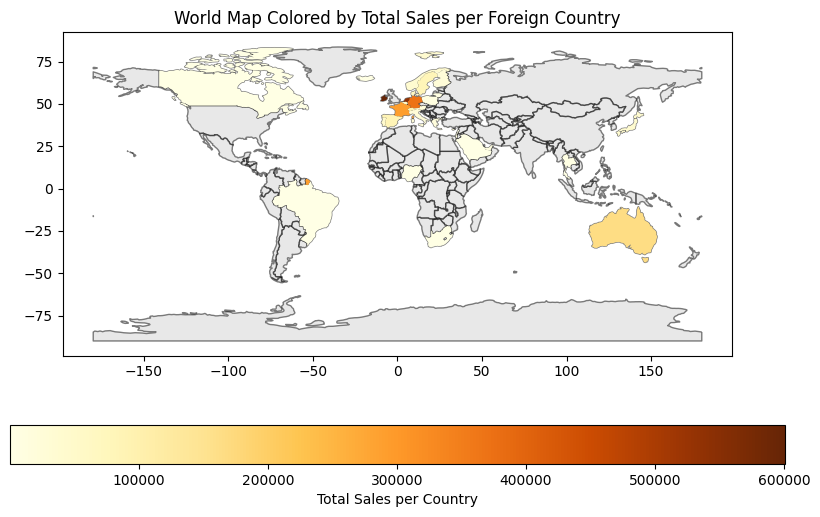

In [40]:
# Removing the UK from the list
foreign_sales_per_country = sales_per_country.iloc[1:]

# Let's plot it again on the world map
reload(plt)

world = gpd.read_file('/content/map/ne_110m_admin_0_countries.shp')

# Setting the index for geopandas 'NAME' and merging the map with our data
world = world.set_index('NAME').join(foreign_sales_per_country)

# Definin a fig and an ax to plot on
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(color='lightgrey', edgecolor="black", alpha=0.5, ax=ax)
world.plot(column='OrderValue', cmap='YlOrBr', legend=True,
                 legend_kwds={'label': "Total Sales per Country",
                              'orientation': "horizontal"}, ax=ax)

plt.title('World Map Colored by Total Sales per Foreign Country')
plt.show()

Again, since most of the sales happened in the UK, plotting the top 15 countries against each other wouldn't be very informative. Instead, let's look at the top 15 foreign countries.

In [41]:
# Slicing the data frame to get the top countries from the 2nd to the 16th
top_15_foreign = sales_only.groupby('Country')['OrderValue'].sum().sort_values(ascending=False).iloc[1:16]
print(top_15_foreign)

Country
Ireland           600,906.82
Netherlands       539,329.77
Germany           371,818.26
France            291,851.43
Australia         164,947.82
Switzerland        91,920.16
Spain              85,804.83
Sweden             83,431.06
Denmark            61,248.63
Belgium            55,921.67
Portugal           46,435.45
Channel Islands    42,100.68
Japan              41,136.08
Norway             37,781.50
Italy              27,794.15
Name: OrderValue, dtype: float64


In [42]:
# Top 10 countries per total sales
top_15_countries_list = []
for country in top_15_foreign.index:
  top_15_countries_list.append(country)
print(top_15_countries_list)

['Ireland', 'Netherlands', 'Germany', 'France', 'Australia', 'Switzerland', 'Spain', 'Sweden', 'Denmark', 'Belgium', 'Portugal', 'Channel Islands', 'Japan', 'Norway', 'Italy']


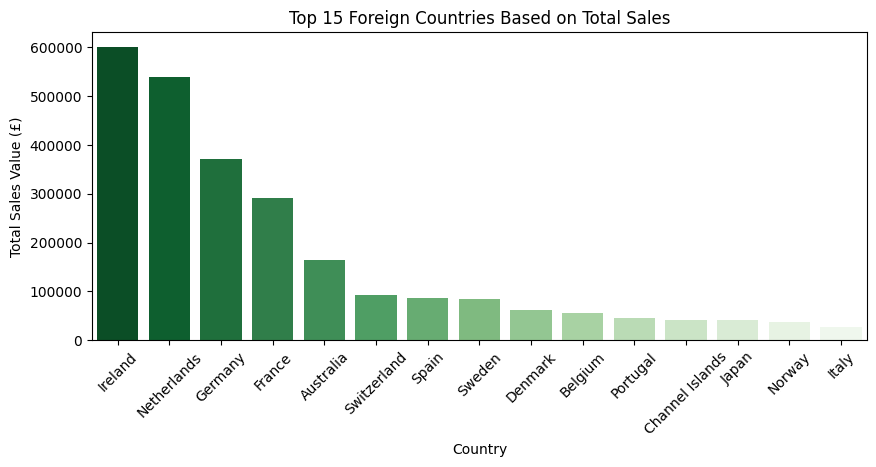

In [43]:
# Plotting the top 15 countries in a bar chart
reload(plt)

colors = sns.color_palette("Greens", n_colors=len(top_15_foreign))

plt.figure(figsize=(10, 4))
sns.barplot(x=top_15_foreign.index, y=top_15_foreign.values, hue=top_15_foreign.index, palette="Greens_r", legend=False)

plt.title('Top 15 Foreign Countries Based on Total Sales')
plt.ylabel('Total Sales Value (£)')
plt.xticks(rotation=45)

plt.show()

Among the top 15 foreign countries, the highest sales were made in Ireland, with a value over £600,000, while the lowest sales were recorded in Italy, with sales below £30,000.

In [44]:
# Creating a subset with the top 15 countries
top_15_countries = sales_only[sales_only['Country'].isin(top_15_countries_list)]

In [45]:
# Let's create a pivot table and examine the order values for each year
top_15_pivot = top_15_countries.pivot_table(index='Country', values='OrderValue', columns='Year', fill_value=0, aggfunc='sum')
top_15_pivot.reset_index()
top_15_pivot['TotalSales'] = top_15_pivot[2009] + top_15_pivot[2010] + top_15_pivot[2011]
top_15_pivot_sorted = top_15_pivot.sort_values('TotalSales', ascending=False)
top_15_pivot_sorted.drop('TotalSales', axis=1)
print(top_15_pivot_sorted)

Year                 2009       2010       2011  TotalSales
Country                                                    
Ireland         16,978.80 332,883.35 251,044.67  600,906.82
Netherlands     13,680.02 255,230.04 270,419.71  539,329.77
Germany          7,902.53 177,805.43 186,110.30  371,818.26
France           5,683.09 114,070.75 172,097.59  291,851.43
Australia          160.80  29,934.50 134,852.52  164,947.82
Switzerland        449.60  40,772.55  50,698.01   91,920.16
Spain            7,754.18  27,808.40  50,242.25   85,804.83
Sweden             285.30  50,425.63  32,720.13   83,431.06
Denmark          1,365.66  43,710.79  16,172.18   61,248.63
Belgium            287.60  20,710.46  34,923.61   55,921.67
Portugal         2,610.89  19,183.21  24,641.35   46,435.45
Channel Islands    963.68  21,789.26  19,347.74   42,100.68
Japan                0.00  12,528.50  28,607.58   41,136.08
Norway             365.31   9,224.25  28,191.94   37,781.50
Italy              422.35  12,908.77  14

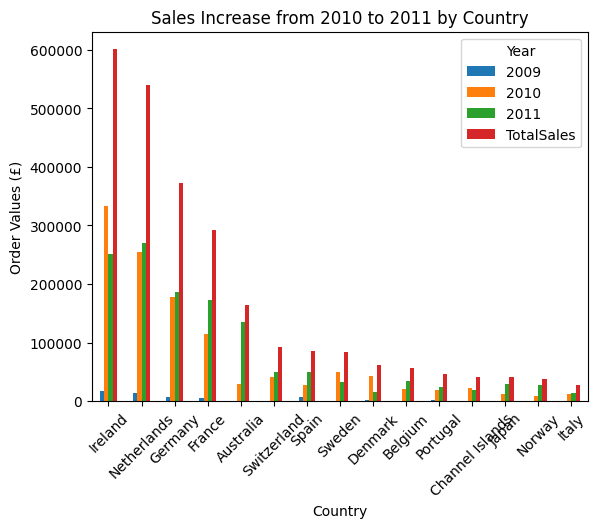

In [46]:
# Visualizing the pivot table
top_15_pivot_sorted.plot(
    kind='bar',
    title='Sales Increase from 2010 to 2011 by Country',
    ylabel='Order Values (£)',
    rot=45)
plt.show()

According to the table above, the e-shop managed to successfully expand abroad, since there was an increase in sales in most these of countries from 2010 to 2011.

### **3**. How many new customers were there each month?
Let's go back to the whole market and calculate how many new customers we have each month in the two year period.

In [47]:
# To check if a given customer ID is new or an existing one, we add a new column using numpy's where() function
sales_only['Occurrence'] = np.where(sales_only['Customer ID'].duplicated(),'Existing', 'New')

In [48]:
# We are also going to need a year-month column since we have three years and the months would repeate
sales_only['YearMonth'] = pd.to_datetime(sales_only['InvoiceDate']).dt.strftime('%Y-%m')

In [49]:
# Finally, let's see the monthly number of existing and new customers
customers_per_month = sales_only.groupby('YearMonth')['Occurrence'].value_counts()

# Check the first few rows
print(customers_per_month.head(10))

YearMonth  Occurrence
2009-12    Existing      40830
           New             951
2010-01    Existing      28932
           New             365
2010-02    Existing      26731
           New             376
2010-03    Existing      38050
           New             440
2010-04    Existing      31684
           New             292
Name: count, dtype: int64


Let's see the average number of monthly new customers. Unless the shop started running in 2019 December, we cannot know which customers marked as 'Existing' are surely new. For this reason, I'm going to omit 2019 December as we don't have access to previous data.

In [50]:
# To convert it into a proper data frame, I will unstack Occurrence to have separate columns for 'Existing' and 'New' values
customers_2009_2010_2011 = customers_per_month.unstack(level='Occurrence')

# Calculating new values by filtering for 'New' and dropping the first line (2019 December)
customers_2010_2011 = customers_2009_2010_2011.iloc[1:].reset_index()

# Calculating the average monthly number of new customers
print(f"The average number of the monthly new customers is: {customers_2010_2011['New'].mean().round(2)}")

The average number of the monthly new customers is: 203.92


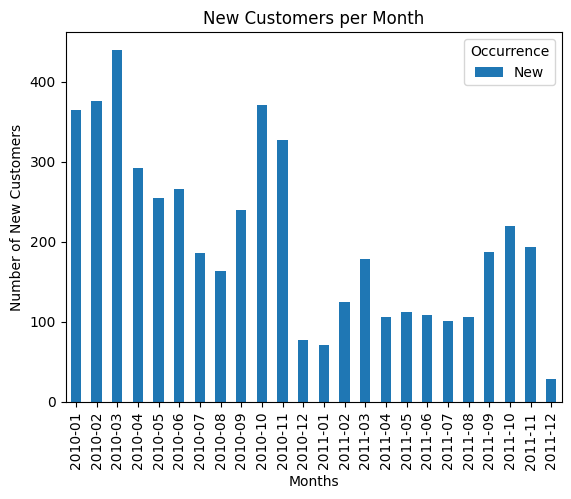

In [51]:
# Creating a subset for the plot
new_customers_2010_2011 = customers_2010_2011.reset_index(drop=True)
new_customers_2010_2011 = new_customers_2010_2011[['YearMonth', 'New']]
new_customers_2010_2011 = new_customers_2010_2011.set_index('YearMonth')

# See the values in a bar chart
new_customers_2010_2011.plot(
    kind='bar',
    title='New Customers per Month',
    xlabel='Months',
    ylabel='Number of New Customers'
    )
plt.show()

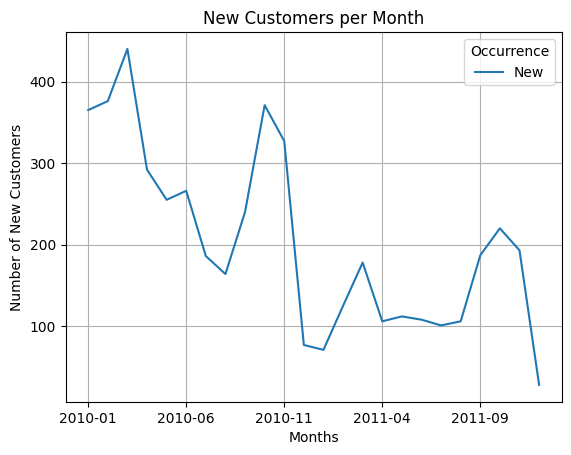

In [52]:
# Let's plot the data on a line chart
new_customers_2010_2011.plot(
    kind='line',
    title='New Customers per Month',
    grid=True,
    xlabel='Months',
    ylabel='Number of New Customers'
    )

plt.show()

Based on the the graphs above, there seemed to be a slight downward tendency in monthly new customers; however, there were still peaks each year towards the winter holidays, and the average was about 200 new customers each month.

### **4**. When did customers make the most purchases?
Let's see our sales numbers plotted on a line chart.

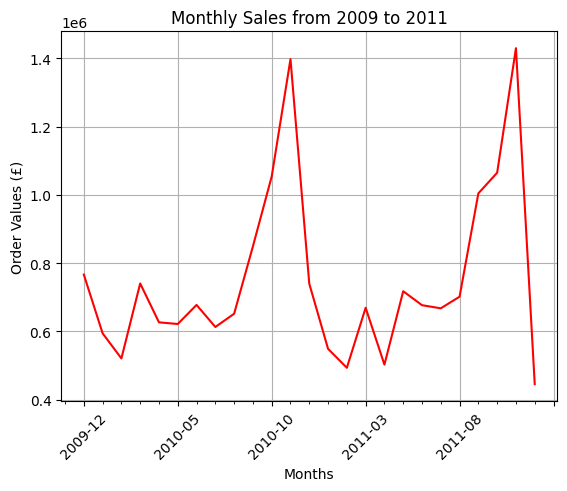

In [53]:
# Grouping sales by year-month and adding the order values for each month
sales_by_date = sales_only.groupby('YearMonth')['OrderValue'].sum()

# Creating a line plot of the order values by date
sales_by_date.plot(
    x='YearMonth',
    y='OrderValue',
    kind='line',
    title='Monthly Sales from 2009 to 2011',
    grid=True,
    color='red',
    xlabel='Months',
    ylabel='Order Values (£)',
    rot=45
)
ax = plt.gca()
# Adding extra ticks for months
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.show()

As you may have guessed, the highest number of sales was recorded in November each year, just before Christmas. We can also notice smaller spikes in March each year, before Easter.

In [54]:
# Let's see the ditribution of the monthly sales
sales_by_date_df = sales_by_date.reset_index()

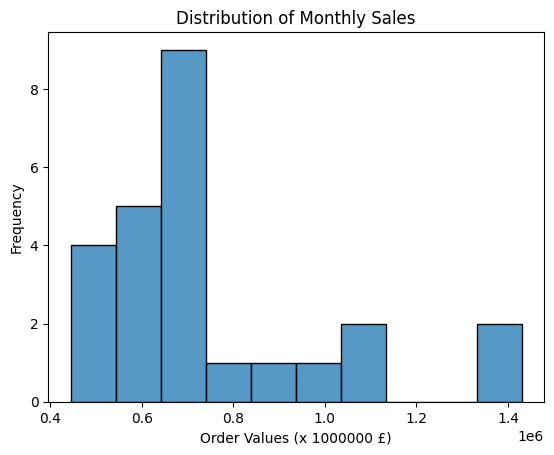

In [89]:
# Plotting a histogram
sns.histplot(data=sales_by_date_df, x='OrderValue')
plt.title('Distribution of Monthly Sales')
plt.xlabel('Order Values (x 1000000 £)')
plt.ylabel('Frequency')
plt.show()

The above histogram tells us that the most frequent monthly sales numbers are around £700,000, while some months reach values over £1,000,000.

### **5**. What are the most frequent terms in the company's product descriptions?

Let's collect and clean the unique descriptions in the sales_only subset and visualize them in a word cloud.

In [56]:
# Filtering the unique descriptions
unique_desc = sales_only['Description'].unique()

# Converting it into a pandas Series object
unique_desc_series = pd.Series(unique_desc)

In [57]:
# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Defining stopwords once to avoid repeated additions inside the loop
stop_words = set(stopwords.words('english'))

# Defining a preprocessing function using NLTK tokenizer
def preprocess_text(text):
    text = text.lower()  # Converting texts to lowercase
    text = re.sub(r'\d+', '', text)  # Removing digits using regex
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation using regex
    tokens = word_tokenize(text)  # Tokenizing the text using NLTK's tokenizer
    cleaned_text = [word for word in tokens if word not in stop_words]  # Removing stopwords
    return ' '.join(cleaned_text)  # Joining each text back into a string

# Applying the function to the unique product descriptions
cleaned_descriptions = unique_desc_series.apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
# Joining all the cleaned descriptions and splitting them into words
all_words = ' '.join(cleaned_descriptions).split()

# Creating a frequency distribution of the words
freq_dist = FreqDist(all_words)

# Let's see the 20 most common words
top_20_words = freq_dist.most_common(20)
print(top_20_words)

[('set', 503), ('pink', 431), ('blue', 329), ('heart', 285), ('red', 283), ('vintage', 272), ('glass', 211), ('bag', 206), ('christmas', 198), ('white', 193), ('box', 174), ('design', 171), ('flower', 165), ('rose', 163), ('candle', 159), ('metal', 151), ('small', 151), ('large', 143), ('green', 141), ('black', 139)]


In [59]:
# Creating a list of words that don't offer us insights into the popular terms
redundant_words = ['set', 'pink', 'blue', 'red', 'white', 'green', 'black', 'pack', 'design', 'yellow', 'large', 'small']
for word in all_words:
  if word in redundant_words:
    all_words.remove(word)

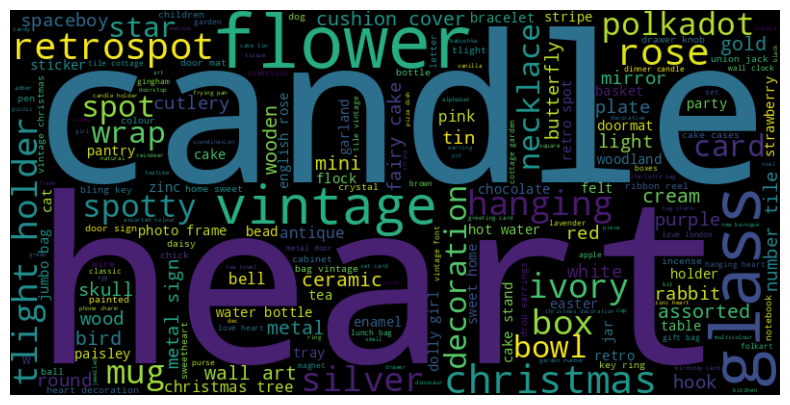

In [60]:
# Generating a WordCloud plot using the word frequency
wordcloud_1 = WordCloud(width=800, height=400, background_color='black').generate(' '.join(all_words))

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

Apparently, 'heart', 'candle', and 'flower' are the most often appearing terms in the product descriptions, followed by 'vintage', 'glass', and 'christmas'.

### **6**. Which was the best-selling product in each country?


In [61]:
# Grouping by country and counting product descriptions to get the best-selling products for each country
best_selling_products = sales_only.groupby('Country')['Description'].value_counts()

# Converting it to a DataFrame by resetting the index and turning it into a new column
best_selling_df = best_selling_products.reset_index(name='SoldNo')

# Let's see the most often sold products for each country
top_products = best_selling_df.loc[best_selling_df.groupby('Country')['SoldNo'].idxmax()]
print(top_products)

                    Country                          Description  SoldNo
0                 Australia        RED TOADSTOOL LED NIGHT LIGHT      13
820                 Austria  ROUND SNACK BOXES SET OF4 WOODLAND        8
1399                Bahrain    CERAMIC CAKE BOWL + HANGING CAKES       2
1501                Belgium  ROUND SNACK BOXES SET OF4 WOODLAND       49
2567                Bermuda    ASSORTED ICE CREAM FRIDGE MAGNETS       1
2601                 Brazil           COOK WITH WINE METAL SIGN        2
2688                 Canada         COLOURING PENCILS BROWN TUBE       3
2896        Channel Islands             REGENCY CAKESTAND 3 TIER      12
3705                 Cyprus             REGENCY CAKESTAND 3 TIER      14
4533         Czech Republic  12 PENCILS SMALL TUBE RED RETROSPOT       1
4556                Denmark                 DOLLY GIRL LUNCH BOX      12
5007     European Community            BISCUIT TIN VINTAGE GREEN       2
5056                Finland      CHILDRENS CUTLERY 

In many countries, the number of the most sold item is one. In this case, it's hard to decide which item was the most popular, since there are many unique products that were purchased only once.

### **7**. Which were the most popular products in 2009, 2010 and 2011?

Let's take a quick look at the top 3 favourite products in each year.

In [62]:
# Grouping by 'Year' and counting the product descriptions for each group
top_products_per_year = sales_only.groupby('Year')['Description'].value_counts()

# Converting it to a df by resetting the index and turning it into a new column ('Count')
top_products_per_year_df = top_products_per_year.reset_index(name='Count')

# Sorting the new df's values in an ascending yearly order and a descending order by the products' counts
top_products_per_year_df = top_products_per_year_df.sort_values(['Year', 'Count'], ascending=(True, False))

# Checking the top 3 products for each year
yearly_bestsellers = top_products_per_year_df.groupby('Year').head(3)
print(yearly_bestsellers)

      Year                         Description  Count
0     2009  WHITE HANGING HEART T-LIGHT HOLDER    305
1     2009        SCOTTIE DOG HOT WATER BOTTLE    227
2     2009   HOT WATER BOTTLE TEA AND SYMPATHY    192
2995  2010  WHITE HANGING HEART T-LIGHT HOLDER   3135
2996  2010            REGENCY CAKESTAND 3 TIER   2031
2997  2010      STRAWBERRY CERAMIC TRINKET BOX   1518
7408  2011  WHITE HANGING HEART T-LIGHT HOLDER   2029
7409  2011             JUMBO BAG RED RETROSPOT   1949
7410  2011            REGENCY CAKESTAND 3 TIER   1781


Although our 2009 data is only available for December, the "White hanging heart T-light holder" seems to have been very popular throughout the years.

### **8**. What was the product return rate?

Since the number of unique transactions is a lot lower than the number of purchase rows, it is safe to assume that more purchases were done under the same invoice ID.

In [63]:
# Checking the dataframe before it was cleaned of cancellation-purchase row pairs
c_transactions = returns_and_canc['Invoice'].nunique()
print(f"The number of unique cancellation transactions is {c_transactions}.")

all_transactions = commerce_products_df['Invoice'].nunique()
print(f"The number of all unique transactions is {all_transactions}.")

The number of unique cancellation transactions is 7411.
The number of all unique transactions is 47934.


In [64]:
# Checking various rates and ratios
print(f"The rate of transactions affected by cancellations is: {round((returns_and_canc.shape[0] / all_transactions)*100, 2)}%")
print(f"The product return/cancellation ratio compared to the purchase rows is: {round((returns_and_canc.shape[0] / sales_only.shape[0]), 2)}")

# Let's see the percentage of all returned products
returned_products = returns_and_canc['Quantity'].sum()
purchased_products = sales_only['Quantity'].sum()

print(f"The percentage of cancelled/returned products of all purchases is: {round((-returned_products / purchased_products)*100, 2)}%")

The rate of transactions affected by cancellations is: 37.38%
The product return/cancellation ratio compared to the purchase rows is: 0.02
The percentage of cancelled/returned products of all purchases is: 4.37%


According to recent e-commerce [data](https://builtforgrowthdigital.com/navigating-ecommerce-returns-trends-and-insights-for-uk-businesses/#:~:text=The%20Current%20Landscape%20of%20eCommerce,with%20a%20charged%20returns%20policy), the average online return rate in the UK in 2023 was between 20-30%. Our data shows that 37.38% of transactions were affected by returns/cancellations; however, only 4.37% of the purchased products were returned. The reason why the first value is higher than the average while the second value is low might be caused by the fact that not all products purchased in a given transaction were returned.

### **9**. Which were the most often returned products?

In [65]:
# Check which were the most frequently returned products
returned_products = returns_and_canc.groupby('Description')['Quantity'].sum().sort_values(ascending=True)
print(returned_products.head(10))

Description
PAPER CRAFT , LITTLE BIRDIE           -80995
MEDIUM CERAMIC TOP STORAGE JAR        -74494
ROTATING SILVER ANGELS T-LIGHT HLDR    -9381
SET/6 FRUIT SALAD PAPER CUPS           -7140
SET/6 FRUIT SALAD  PAPER PLATES        -7008
POP ART PEN CASE & PENS                -5184
BLACK SILVER FLOWER T-LIGHT HOLDER     -5040
MULTICOLOUR SPRING FLOWER MUG          -4996
TEATIME PEN CASE & PENS                -4632
WHITE BIRD GARDEN DESIGN MUG           -4320
Name: Quantity, dtype: int64


In [66]:
# Let's take a look at the top 3, both positive and negative quantity values to compare the dates in the data frame cleaned of extra fees
top_3_returned = commerce_products_df[(commerce_products_df['Description'] =='PAPER CRAFT , LITTLE BIRDIE') |
                              (commerce_products_df['Description'] =='MEDIUM CERAMIC TOP STORAGE JAR') |
                              (commerce_products_df['Description'] =='ROTATING SILVER ANGELS T-LIGHT HLDR')]
top_3_returned = top_3_returned.sort_values(by='Quantity', ascending=True)
top_3_returned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,OrderValue
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,"-168,469.60"
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,"-77,183.60"
4268,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,-280.80
234364,C557508,23166,MEDIUM CERAMIC TOP STORAGE JAR,-240,2011-06-20 16:13:00,1.04,16684.0,United Kingdom,-249.60
394002,C570867,23166,MEDIUM CERAMIC TOP STORAGE JAR,-12,2011-10-12 16:17:00,1.25,12607.0,USA,-15.00
...,...,...,...,...,...,...,...,...,...
326846,521315,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1920,2010-09-03 12:01:00,1.66,15838.0,United Kingdom,"3,187.20"
379875,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3120,2010-10-08 10:10:00,1.66,15838.0,United Kingdom,"5,179.20"
432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838.0,United Kingdom,"15,818.40"
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,"77,183.60"


Interestingly, the head and tail values for the top 3 most returned products mirror each other, meaning that those quantities were purchased in bulk. If we take a look at the purchase and return dates, we'll notice that for the top 2 returned items, the return log times were within 20 minutes from the purchase log times, so those products never made it to the buyer, the orders were cancelled before shipping. In the case of the third product (rotating silver angels), the return order of 9360 items was made over a month after the purchase date, which likely means that the products were returned after their receipt. In this case, the prices are also different, which probably indicates that the the customer only got back a fraction of the originally paid price (£280). This is also the reason why the above code looking for purchase row and cancellation row matches didn't flag this row to be removed: the order values were different.

### **10**. When were the largest orders made? & **11**. Which customers made the largest orders?


In [67]:
# Let's sort the sales rows by the order value in descending order; these are only the orders that didn't get cancelled
top_orders = sales_only.sort_values(by='OrderValue', ascending=False).head(10)
top_orders

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,OrderValue,Year,Occurrence,YearMonth
432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838.0,United Kingdom,"15,818.40",2010,Existing,2010-11
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008.0,United Kingdom,"8,925.00",2010,Existing,2010-06
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,"7,144.72",2011,Existing,2011-09
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,"6,539.40",2011,Existing,2011-04
461644,533027,22086,PAPER CHAIN KIT 50'S CHRISTMAS,835,2010-11-15 16:02:00,6.95,No data,United Kingdom,"5,803.25",2010,Existing,2010-11
379875,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3120,2010-10-08 10:10:00,1.66,15838.0,United Kingdom,"5,179.20",2010,Existing,2010-10
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,"4,992.00",2011,Existing,2011-10
467804,576365,22086,PAPER CHAIN KIT 50'S CHRISTMAS,688,2011-11-14 17:55:00,6.95,No data,United Kingdom,"4,781.60",2011,Existing,2011-11
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.40,15749.0,United Kingdom,"4,632.00",2011,New,2011-04
358821,524181,21622,VINTAGE UNION JACK CUSHION COVER,648,2010-09-27 16:59:00,6.89,17450.0,United Kingdom,"4,464.72",2010,Existing,2010-09


The top 5 highest sales orders were made in the UK by 5 different existing customers: three sales in 2010 and two in 2011. Even though the 9360 rotating silver angels were eventually returned, the client did not get back most of his money, so it still counts as a high-value purchase. Interestingly, only 3 out of the top 10 largest orders (invoice nos. 576365, 533027, 525968) were related to Christmas purchases.

### **12**. Who were the biggest clients based on sales?

In [68]:
# Let's find out which customers spent the most over the years
top_customers = sales_only.groupby('Customer ID')['OrderValue'].sum().sort_values(ascending=False)
print(top_customers.head(11))

Customer ID
No data   2,535,442.78
18102.0     577,316.12
14646.0     516,552.47
14156.0     295,341.12
14911.0     259,411.96
17450.0     234,759.35
13694.0     188,630.47
17511.0     168,599.20
12415.0     142,273.42
16684.0     141,174.27
15061.0     119,156.85
Name: OrderValue, dtype: float64


Not counting the customers who had no ID, we can see that the top 10 clients all spent above £100,000.

In [69]:
# Let's see all the clients who spent over £100,000
above_100k_customers = top_customers[top_customers >= 100000].iloc[1:]

Let's plot our data.

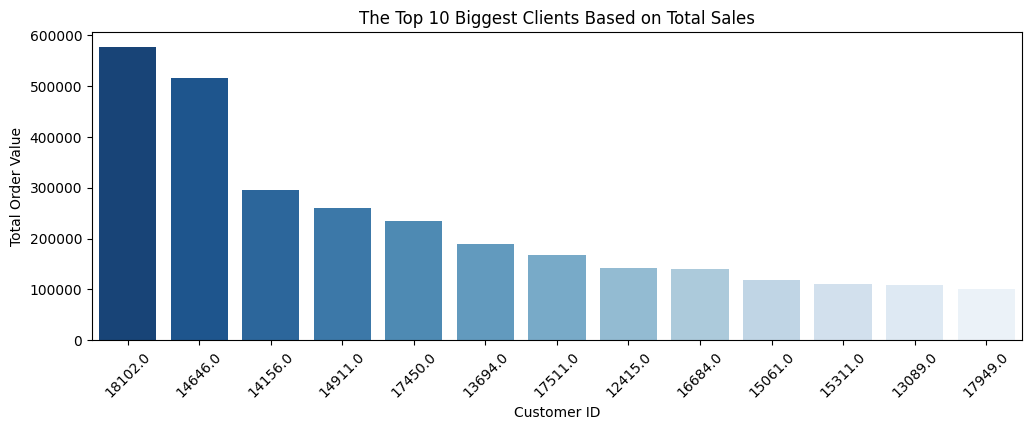

In [70]:
# Since we've already defined plt.xlabel and plt.ylabel, we need to reload plt to avoid getting an error
reload(plt)

colors = sns.color_palette("Blues", n_colors=len(above_100k_customers))

plt.figure(figsize=(12,4))
sns.barplot(x=above_100k_customers.index, y=above_100k_customers.values, hue=above_100k_customers.values, palette=colors, legend=False)

plt.ylabel('Total Order Value')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.title('The Top 10 Biggest Clients Based on Total Sales')

plt.show()

### **13**. Who were the most valued clients based on the RFM score?

Let's an RFM analysis on the customers. RFM is customer segmentation technique used for businesses to understand customer behaviour and predict their actions in the future. It quantitatively ranks and groups customers based on the following metrics:

**Recency** (**R**): How recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

**Frequency** (**F**): How often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

**Monetary** (**M**): The total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

We will calculate these metrics separately and then merge the resulting df's together.

In [71]:
# Calculating the most recenct purchases
rfm_df = sales_only.groupby('Customer ID')['InvoiceDate'].max().reset_index()

# Most recent purchase in the dataset
most_recent_purchase = rfm_df['InvoiceDate'].max()
most_recent_purchase = pd.to_datetime(most_recent_purchase)

# Calculating the number of days since each customer's last purchase
rfm_df['DaysSinceLastPurchase'] =  (most_recent_purchase - rfm_df['InvoiceDate']).dt.days
rfm_df.drop(columns=['InvoiceDate'], inplace=True)
rfm_df.head()

,Customer ID,DaysSinceLastPurchase
0,12346.0,528
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [72]:
# Calculating total transactions per customer
total_transactions = sales_only.groupby('Customer ID')['Invoice'].nunique().reset_index()
print(total_transactions)

     Customer ID  Invoice
0        12346.0       11
1        12347.0        8
2        12348.0        5
3        12349.0        3
4        12350.0        1
...          ...      ...
5840     18284.0        1
5841     18285.0        1
5842     18286.0        2
5843     18287.0        7
5844     No data     3133

[5845 rows x 2 columns]


In [73]:
# Calculating the total number of products purchased by each customer
purchased_quantity = sales_only.groupby('Customer ID')['Quantity'].sum().reset_index()
purchased_quantity.rename(columns={'Quantity': 'PurchasedQuantity'}, inplace=True)
print(purchased_quantity)

     Customer ID  PurchasedQuantity
0        12346.0                 70
1        12347.0               2869
2        12348.0               2560
3        12349.0               1579
4        12350.0                184
...          ...                ...
5840     18284.0                493
5841     18285.0                144
5842     18286.0                595
5843     18287.0               3012
5844     No data             732089

[5845 rows x 2 columns]


In [74]:
# Calculating the total spend of each customer
customer_total_spend = sales_only.groupby('Customer ID')['OrderValue'].sum().reset_index()
print(customer_total_spend)

     Customer ID   OrderValue
0        12346.0       372.86
1        12347.0     4,700.31
2        12348.0     1,594.80
3        12349.0     3,615.51
4        12350.0       269.20
...          ...          ...
5840     18284.0       411.68
5841     18285.0       377.00
5842     18286.0     1,165.43
5843     18287.0     4,132.99
5844     No data 2,535,442.78

[5845 rows x 2 columns]


In [75]:
# Let's see the unique products purchased by each customer
unique_products = sales_only.groupby('Customer ID')['Description'].nunique().reset_index()
print(unique_products)

     Customer ID  Description
0        12346.0           25
1        12347.0          125
2        12348.0           27
3        12349.0          144
4        12350.0           15
...          ...          ...
5840     18284.0           27
5841     18285.0           11
5842     18286.0           64
5843     18287.0          119
5844     No data         4637

[5845 rows x 2 columns]


In [76]:
# Finally, let's see if the customer's country was the UK or a foreign country
customer_country = sales_only.groupby(['Customer ID', 'Country']).size().reset_index(name='NumberOfTransactions')
customer_main_country = customer_country.sort_values(by='NumberOfTransactions', ascending=False)
print(customer_main_country)

     Customer ID         Country  NumberOfTransactions
5868     No data  United Kingdom                221113
5412     17841.0  United Kingdom                 12202
2528     14911.0         Ireland                 10615
405      12748.0  United Kingdom                  6419
2230     14606.0  United Kingdom                  6132
...          ...             ...                   ...
5111     17533.0  United Kingdom                     1
2204     14580.0  United Kingdom                     1
4014     16417.0  United Kingdom                     1
1497     13864.0  United Kingdom                     1
2732     15118.0  United Kingdom                     1

[5870 rows x 3 columns]


In [77]:
# Checking if any customers have made purchases in other countries too and remove them if they did (we need their main country)
duplicates = customer_main_country['Customer ID'].duplicated().reset_index(name='Customer ID')
duplicates_df = pd.DataFrame(duplicates)
duplicates_df['Customer ID'].value_counts()

,count
Customer ID,
False,5845
True,25


In [78]:
# Dropping duplicate customer IDs
customer_main_country.drop_duplicates('Customer ID', inplace=True)

# Checking if the customer's main country is the UK or not
customer_main_country['IsUK'] = customer_main_country['Country'].apply(lambda x: 'Yes' if x == 'United Kingdom' else 'No')

In [79]:
# Let's merge these data frames into the first one; since these df's only contain two columns, we don't need to specify them
rfm_df = pd.merge(rfm_df, total_transactions, on='Customer ID')
rfm_df = pd.merge(rfm_df, purchased_quantity, on='Customer ID')
rfm_df = pd.merge(rfm_df, customer_total_spend, on='Customer ID')
rfm_df = pd.merge(rfm_df, unique_products, on='Customer ID')

# In this case, we have multiple columns so we need to specify which two we need
rfm_df = pd.merge(rfm_df, customer_main_country[['Customer ID', 'IsUK']], on='Customer ID', how='left')

# Renaming some column names for clarity
rfm_df.rename(columns={'Invoice': 'TotalInvoices'}, inplace=True)
rfm_df.rename(columns={'OrderValue': 'TotalSpend'}, inplace=True)
rfm_df.rename(columns={'Description': 'UniqueProducts'}, inplace=True)

# Let's add another column for the average transaction value
rfm_df['AvgSpendPerTransact'] = rfm_df['TotalSpend'] / rfm_df['TotalInvoices']
rfm_df = rfm_df.sort_values(by='TotalSpend', ascending=False)

print(rfm_df.head())

     Customer ID  DaysSinceLastPurchase  TotalInvoices  PurchasedQuantity  \
5844     No data                      0           3133             732089   
5658     18102.0                      0            145             180373   
2258     14646.0                      1            145             360402   
1775     14156.0                      9            142             161442   
2516     14911.0                      0            370             142237   

       TotalSpend  UniqueProducts IsUK  AvgSpendPerTransact  
5844 2,535,442.78            4637  Yes               809.27  
5658   577,316.12             412  Yes             3,981.49  
2258   516,552.47            1045   No             3,562.43  
1775   295,341.12            1558   No             2,079.87  
2516   259,411.96            2708   No               701.11  


In [80]:
# Since the first row contains the customers without a customer ID (registered account), we can drop that row
rfm_df = rfm_df.iloc[1:, :]

In [81]:
# Let's create our R, F, M, and combined RFM score columns by splitting up the data into five quantiles

rfm_df['R_rank'] = pd.cut(rfm_df['DaysSinceLastPurchase'], bins=5, labels=range(5, 0, -1))
rfm_df['F_rank'] = pd.cut(rfm_df['TotalInvoices'], bins=5, labels=range(1, 6, 1))
rfm_df['M_rank'] = pd.cut(rfm_df['TotalSpend'], bins=5, labels=range(1, 6, 1))

rfm_df['CombinedRFM'] = rfm_df['R_rank'].astype(int) + rfm_df['F_rank'].astype(int) + rfm_df['M_rank'].astype(int)

rfm_df.rename(columns={'DaysSinceLastPurchase':'Recency'}, inplace=True)
rfm_df.rename(columns={'TotalInvoices':'Frequency'}, inplace=True)
rfm_df.rename(columns={'TotalSpend':'Monetary'}, inplace=True)

rfm_df = rfm_df.sort_values(by='CombinedRFM', ascending=False)

In [82]:
# Although the purchased quantity and unique products can be informative, in this case, let's focus on the RFM score
rfm_only = rfm_df.drop(['PurchasedQuantity', 'UniqueProducts'], axis=1)
rfm_only.head(15)

,Customer ID,Recency,Frequency,Monetary,IsUK,AvgSpendPerTransact,R_rank,F_rank,M_rank,CombinedRFM
2516,14911.0,0,370,"259,411.96",No,701.11,5,5,3,13
5658,18102.0,0,145,"577,316.12",Yes,"3,981.49",5,2,5,12
2258,14646.0,1,145,"516,552.47",No,"3,562.43",5,2,5,12
393,12748.0,0,319,"46,483.86",Yes,145.72,5,5,1,11
1775,14156.0,9,142,"295,341.12",No,"2,079.87",5,2,3,10
729,13089.0,2,201,"108,718.02",Yes,540.89,5,3,1,9
2912,15311.0,0,205,"110,939.94",Yes,541.17,5,3,1,9
5400,17841.0,1,211,"66,954.34",Yes,317.32,5,3,1,9
2663,15061.0,3,124,"119,156.85",Yes,960.94,5,2,2,9
2218,14606.0,0,184,"28,661.71",Yes,155.77,5,3,1,9


# Conclusion

During the examined period, the **most valued customer** (14911) with a combined RFM score of 13 was not based in the UK customer; they had 370 transactions in the total value of £259,000! The second most valued client (18102) was based in the UK and got a combined RFM score of 12. Although they spent almost twice as much of what the non-UK-based client in first place, their frequency score was less than half of the score of the first client. Interestingly, the customer in fourth place (12748) only spent about £46,000; however, they scored high in recency and frequency (319 transactions).

Regarding the number of **new clients**, we have seen that the average number of monthly new clients is about 200; however, the data shows a slightly decreasing tendency which might mean that the company does not spend enough on marketing.

**Best selling** and **most returned** products should be analysed in countries where sales were considerable, such as in the top 15 countries. A stock buildup of the former could be a good idea before high seasons (i.e. before the holidays), while the removal of the most returned products from stock is also advisable since returns come with extra logistical fees if the fault lies in the quality of the product. I have considered separating cancelled orders from actual returns based on the time between the purchase and the cancellation/return; however, since I've already had to loop through the whole dataset just to remove cancellation-purchase row pairs, I've decided to omit this functionality for now to keep the code from getting computationally too expensive (there's also no separate column for the return reasons).

As for final **recommendations**, we have seen that the dataset's main problem was inconsistency (marking cancelled orders with different numbers, missing product descriptions, missing cancellation or return reasons or mixed with descriptions, incorrect quantities, mixing country names with region names, and so on) which greatly increases the chances of misinterpretating the data. Proper and consistent data entry is key in identifying trends and making predictions.